In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import multiprocessing
from torch import autograd
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from fasterai.loss import *
from fasterai.models import *
from fastai.torch_imports import *
from pathlib import Path
from itertools import repeat
import tensorboardX
torch.cuda.set_device(0)
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True


/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
DATA_PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
TRAIN_SOURCE_PATH = DATA_PATH/'train'
proj_id = 'bw2color'

D_MODEL_SAVE_PATH = DATA_PATH/(proj_id + '_5004_D.h5')
G_MODEL_SAVE_PATH = DATA_PATH/(proj_id + '_5004_G.h5')
keep_pct=1.0
wd=1e-7
bs = 8
sz = 128
torch.backends.cudnn.benchmark=True

## EDSR Model

##### TODO:  Also try making the loss/output based on "classification" like in Zhang et al.
##### TODO:  After making unet version- plug that into a Weiserman GAN setup (the discrimator looks at grey image and colorized image, concatenated together via channels).
##### TODO:  Try using higher res images (from FloydHub blog?)
##### TODO:  Try perceptual loss again....
##### TODO:  To convert real old photos, could force them to normal grayscale first.
##### TODO:  Add tensorboard graphs

In [4]:
class ImageModifierModel(nn.Module):
    @staticmethod
    def _res_block_upsample(nf):
        layers = []
        layers.append(ConvBlock(nf, nf))
        layers.append(ConvBlock(nf, nf, bn=False, actn=False))
        return ResSequential(layers)
    
    @staticmethod
    def _generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut

    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
    
    def __init__(self):
        super().__init__() 
        rn, lr_cut = ImageModifierModel._generate_base_model()
        self.rn = rn
        set_trainable(rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.up1 = UpSampleBlock(256, 256, 16)  #256 in
        self.up2 = UpSampleBlock(128, 128, 8)  #128 in
        self.up3 = UpSampleBlock(64, 64, 4)    #64 in
        self.up4 = UpSampleBlock(64, 64, 2)   #64 in  
        nf_up = 256+128+64+64+3
        nf_mid = 256  
 
        mid_layers = []
        mid_layers += [ConvBlock(nf_up,nf_mid, bn=True, actn=False)]
        for i in range(8): 
            mid_layers.append(ImageModifierModel._res_block_upsample(nf_mid))
        mid_layers += [ConvBlock(nf_mid,nf_mid, actn=False), 
                       ConvBlock(nf_mid, 3, bn=False, actn=False)]
        self.upconv = nn.Sequential(*mid_layers)
             
        out_layers = []
        out_layers += [ConvBlock(6, 3, ks=1, bn=False, actn=False)]
        self.out = nn.Sequential(*out_layers)
        
    def forward(self, x): 
        self.rn(x)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        x5 = self.upconv(torch.cat([x, x1, x2, x3, x4], dim=1))
        return F.tanh(self.out(torch.cat([x, x5], dim=1)))

## WGAN Critic Model

In [5]:
class Critic2(nn.Module):
    @staticmethod
    def _generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut
    
    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
        
    @staticmethod
    def _generate_eval_layers(nf_in, nf_mid, sz):
        layers = [] 
        layers.append(ConvBlock(nf_in, nf_mid, 4, 2, bn=False))
        csize,cndf = sz//2,nf_mid
        layers.append(nn.LayerNorm([cndf, csize, csize]))
        layers.append(ConvBlock(cndf, cndf, 3, 1, bn=False))
        layers.append(nn.LayerNorm([cndf, csize, csize]))

        while csize > 8:
            layers.append(ConvBlock(cndf, cndf*2, 4, 2, bn=False))
            cndf = int(cndf*2)
            csize = int(csize//2)
            layers.append(nn.LayerNorm([cndf, csize, csize]))
        
        layers.append(nn.Conv2d(cndf, 1, 4, padding=0, bias=False))    
        return nn.Sequential(*layers) 
            
    def __init__(self, sz):
        super().__init__()
         
        rn, lr_cut = Critic2._generate_base_model()
        self.rn = rn
        set_trainable(self.rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.feature_eval_1 = Critic2._generate_eval_layers(256*2, 256, sz//16)
        self.feature_eval_2 = Critic2._generate_eval_layers(128*2, 128, sz//8)
        self.feature_eval_3 = Critic2._generate_eval_layers(64*2, 64, sz//4)
        self.feature_eval_4 = Critic2._generate_eval_layers(64*2, 64, sz//2)     
        self.pixel_eval = Critic2._generate_eval_layers(6, 64, sz)
        
    def forward(self, input, orig):
        self.rn(orig)
        x1 = self.sfs[3].features
        x2 = self.sfs[2].features
        x3 = self.sfs[1].features
        x4 = self.sfs[0].features
        
        self.rn(input)
        y1 = self.sfs[3].features
        y2 = self.sfs[2].features
        y3 = self.sfs[1].features
        y4 = self.sfs[0].features 

        f1 = self.feature_eval_1(torch.cat([x1, y1], dim=1))
        f2 = self.feature_eval_2(torch.cat([x2, y2], dim=1))
        f3 = self.feature_eval_3(torch.cat([x3, y3], dim=1))
        f4 = self.feature_eval_4(torch.cat([x4, y4], dim=1))
  
        p = self.pixel_eval(torch.cat([orig, input], dim=1))
        return f1.mean() + f2.mean() + f3.mean()  + f4.mean() + p.mean()

## Training

In [6]:
netG = ImageModifierModel().cuda()
#load_model(netG, G_MODEL_SAVE_PATH)
netD = Critic2(sz).cuda()
#load_model(netD, D_MODEL_SAVE_PATH)

/media/jason/Projects/Deep Learning/Deep Learning Projects/Jupyter Experiments/1_BlackWhiteToColor/fasterai/models.py:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  subkernel = init(subkernel)
/media/jason/Projects/Deep Learning/Deep Learning Projects/Jupyter Experiments/1_BlackWhiteToColor/fasterai/models.py:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  subkernel = init(subkernel)
/media/jason/Projects/Deep Learning/Deep Learning Projects/Jupyter Experiments/1_BlackWhiteToColor/fasterai/models.py:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  subkernel = init(subkernel)
/media/jason/Projects/Deep Learning/Deep Learning Projects/Jupyter Experiments/1_BlackWhiteToColor/fasterai/models.py:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  subkernel = init(subkernel)


In [7]:
#optimizerD = optim.RMSprop(filter(lambda p: p.requires_grad,netD.parameters()), lr = 1e-4)
#optimizerG = optim.RMSprop(filter(lambda p: p.requires_grad,netG.parameters()), lr = 1e-4)

#optimizerD = optim.RMSprop(filter(lambda p: p.requires_grad,netD.parameters()), lr = 1e-3)
#optimizerG = optim.RMSprop(filter(lambda p: p.requires_grad,netG.parameters()), lr = 1e-3)

#TODO:  Weird beta 1 value, but we'll see...

optimizerD = optim.Adam(filter(lambda p: p.requires_grad,netD.parameters()), lr=1e-4, betas=(0., 0.9))
optimizerG = optim.Adam(filter(lambda p: p.requires_grad,netG.parameters()), lr=1e-4, betas=(0., 0.9))

In [8]:
def calc_gradient_penalty(netD, real_data, fake_data, orig_data):
    lamda = 10 # Gradient penalty lambda hyperparameter
    # print "real_data: ", real_data.size(), fake_data.size()
    alpha = torch.rand(bs, 1)
    alpha = alpha.expand(bs, real_data.nelement()//bs).contiguous().view(bs, 3, sz, sz)
    alpha = alpha.cuda()
    differences = fake_data - real_data
    interpolates = real_data + (alpha*differences)
    interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    disc_interpolates = netD(interpolates, orig_data)
    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lamda
    return gradient_penalty

In [9]:
def progress_update(i, w_dist, gradient_penalty, disc_real, disc_fake, md, netG, netD, ecount):
    if i % 50 == 0:
        print(f'\nWDist {to_np(w_dist)}; GPenalty {to_np(gradient_penalty)}; RScore {to_np(disc_real)};'
          + f' FScore {to_np(disc_fake)}; ECount: {ecount}')

    if i % 500 == 0:
        visualize_image_gen_model(md, netG, 500, 8)
        save_model(netD, D_MODEL_SAVE_PATH)
        save_model(netG, G_MODEL_SAVE_PATH)

def is_equilibrium(disc_real, disc_fake):
    if disc_real < disc_fake:
        return False
        
    return abs(disc_real + disc_fake) < (abs(disc_real) + abs(disc_fake))*0.30

def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        n = n-(n%bs)
        with tqdm(total=n) as pbar:
            while i < n:
                netD.set_trainable(True)
                netG.set_trainable(False)
                j = 0
                equilibrium = False
                while (not equilibrium) and (i < n) and j<10000:
                    j += 1; i += 1
                    #or p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    x, y = next(data_iter)
                    orig_image = V(x)
                    real_image = V(y)                        
                    #Higher == Real
                    disc_real = netD(real_image, orig_image)
                    fake_image = netG(orig_image)
                    disc_fake = netD(V(fake_image.data), orig_image)
                    equilibrium = is_equilibrium(disc_real, disc_fake)
                    
                    netD.zero_grad()
                          
                    gradient_penalty = calc_gradient_penalty(netD, real_image.data, fake_image.data, orig_image)              
                    disc_cost = disc_fake - disc_real + gradient_penalty
                    w_dist = disc_fake - disc_real
                    disc_cost.backward()
                    optimizerD.step()
                    pbar.update()
             
                    progress_update(i, w_dist, gradient_penalty, disc_real, disc_fake, md, netG, netD, gen_iterations)

                    
                netD.set_trainable(False)
                netG.set_trainable(True)
                netG.zero_grad()
                
                x, y = next(data_iter)
                orig_image = V(x)
                real_image = V(y)   
                fake_image = netG(orig_image)
                gen_mse_cost = F.mse_loss(fake_image, real_image)
                gen_cost  = -netD(fake_image, orig_image)
                gen_cost .backward()
                optimizerG.step()
                gen_iterations += 1
                
                progress_update(i, w_dist, gradient_penalty, disc_real, disc_fake, md, netG, netD, gen_iterations)

In [10]:
md = get_matched_image_model_data(image_size=sz, batch_size=bs, root_data_path=DATA_PATH, train_root_path=TRAIN_SOURCE_PATH, proj_id=proj_id, keep_pct=keep_pct)

  0%|          | 50/158544 [00:37<24:04:08,  1.83it/s]
WDist -45.126976013183594; GPenalty 0.13228119909763336; RScore 13.771562576293945; FScore -31.355411529541016; ECount: 14
  0%|          | 100/158544 [01:04<26:02:36,  1.69it/s]
WDist -112.29994201660156; GPenalty 6.066228866577148; RScore 85.86320495605469; FScore -26.436735153198242; ECount: 26
  0%|          | 150/158544 [01:36<17:52:29,  2.46it/s]
WDist -73.76605224609375; GPenalty 6.254810810089111; RScore -20.825084686279297; FScore -94.59114074707031; ECount: 40
  0%|          | 200/158544 [02:07<19:18:45,  2.28it/s]
WDist -83.12313842773438; GPenalty 30.716867446899414; RScore -5.990448951721191; FScore -89.11358642578125; ECount: 58
  0%|          | 250/158544 [02:31<29:30:38,  1.49it/s]
WDist -60.655120849609375; GPenalty 38.170597076416016; RScore 178.90451049804688; FScore 118.2493896484375; ECount: 65
  0%|          | 300/158544 [02:59<20:58:03,  2.10it/s]
WDist -212.39666748046875; GPenalty 11.827422142028809; RScore

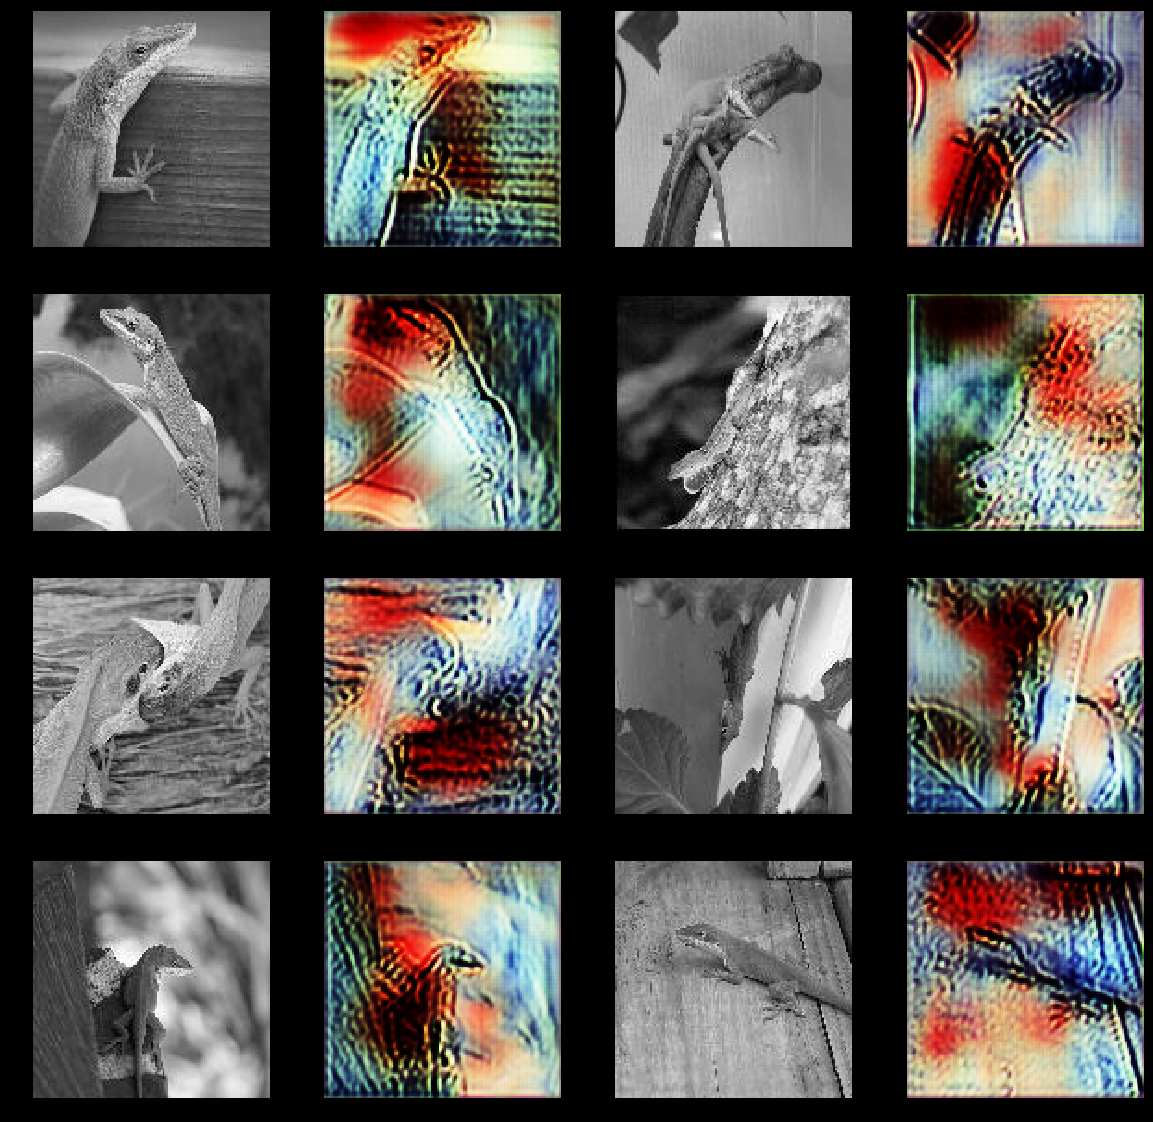

  0%|          | 550/158544 [06:23<23:32:47,  1.86it/s]
WDist -247.6703338623047; GPenalty 45.22498321533203; RScore 230.76910400390625; FScore -16.901229858398438; ECount: 127
  0%|          | 600/158544 [06:53<26:26:55,  1.66it/s]
WDist -450.3471374511719; GPenalty 45.72581481933594; RScore -81.92276000976562; FScore -532.2698974609375; ECount: 142
  0%|          | 650/158544 [07:21<52:33:06,  1.20s/it]
WDist 167.06703186035156; GPenalty 12.521738052368164; RScore 246.0037078857422; FScore 413.07073974609375; ECount: 152
  0%|          | 700/158544 [07:46<37:31:15,  1.17it/s]
WDist -503.07635498046875; GPenalty 60.74898147583008; RScore 140.0975341796875; FScore -362.97882080078125; ECount: 160
  0%|          | 750/158544 [08:14<26:40:11,  1.64it/s]
WDist -76.79376220703125; GPenalty 47.74505615234375; RScore 511.18975830078125; FScore 434.39599609375; ECount: 173
  1%|          | 800/158544 [08:38<18:36:58,  2.35it/s]
WDist -610.7750854492188; GPenalty 29.864961624145508; RScore 251

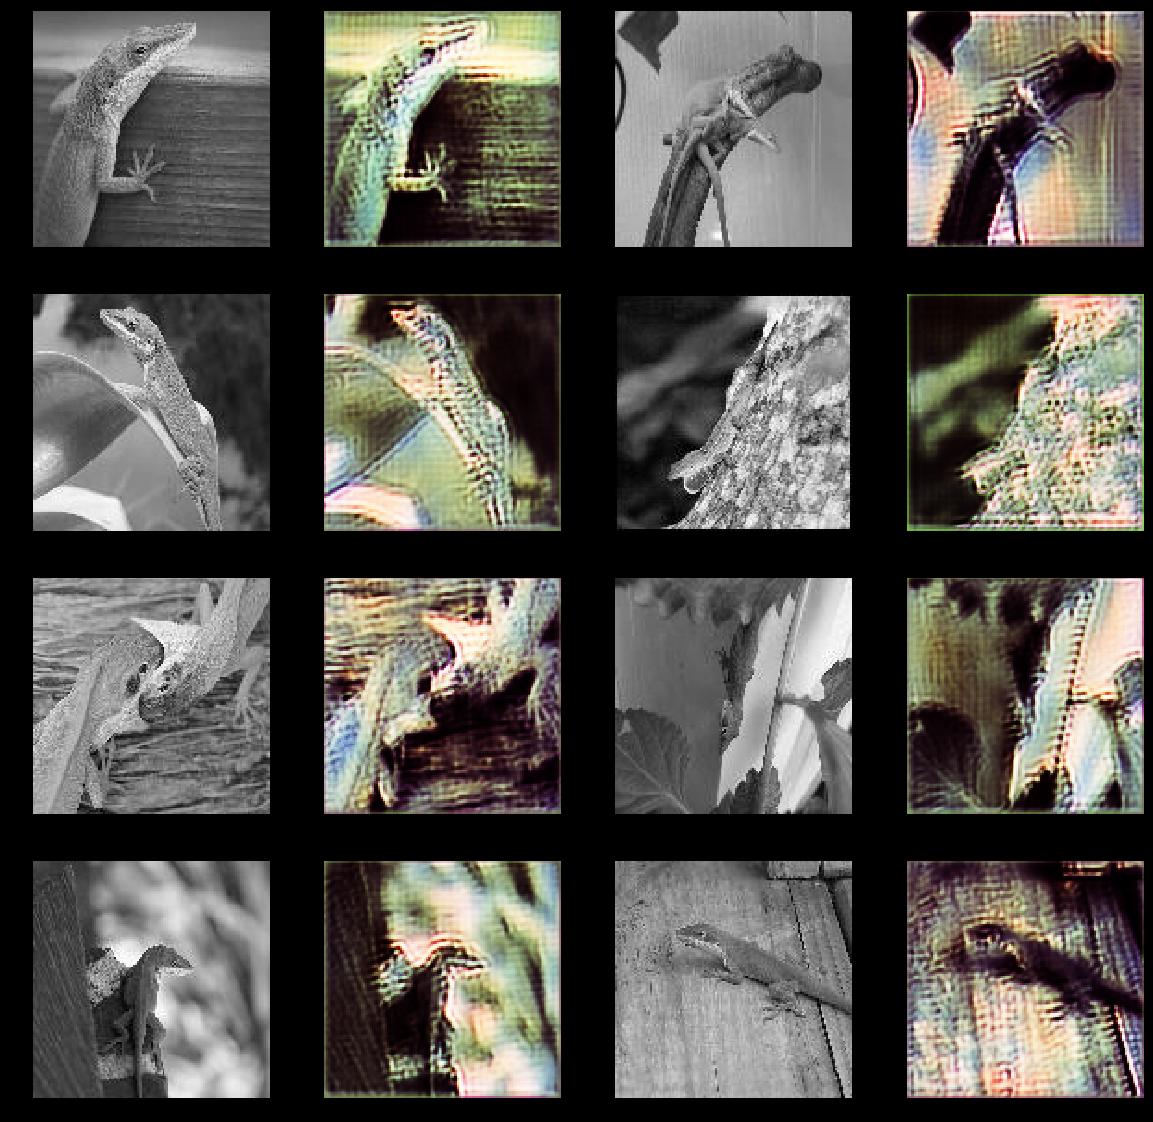

  1%|          | 1050/158544 [12:11<17:26:46,  2.51it/s]
WDist -517.6270141601562; GPenalty 94.57041931152344; RScore -245.3505401611328; FScore -762.9775390625; ECount: 226
  1%|          | 1100/158544 [12:41<21:01:56,  2.08it/s]
WDist -483.1571044921875; GPenalty 29.384944915771484; RScore -329.8739013671875; FScore -813.031005859375; ECount: 236
  1%|          | 1129/158544 [12:55<25:50:57,  1.69it/s]

In [ ]:
train(1, True)
#train(1, False)

In [ ]:
train(9, False)